<a href="https://colab.research.google.com/github/wtliu1/ECON441B/blob/main/Week_7_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WENTAO LIU 206085049**

# 1.) Import an asset price from Yahoo Finance

In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("^IRX", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [33]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 5
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))



model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6447/6447 [==============================] - 35s 5ms/step - loss: 0.1415
Epoch 2/3
6447/6447 [==============================] - 31s 5ms/step - loss: 0.1321
Epoch 3/3
6447/6447 [==============================] - 30s 5ms/step - loss: 0.1319


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [34]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predictions = model.predict(x_test)



51/51 [==============================] - 1s 3ms/step


In [35]:
# In Sample Random Walk
y_true_in_sample = y_train[1:] # actual
y_pred_in_sample = y_train[:-1] # predict

# out of sample Random Walk
y_true_out_sample = y_test[1:] # actual
y_pred_out_sample = y_test[:-1] # predict

In [36]:
from sklearn.metrics import mean_squared_error

# Calculate accuracy
in_sample_acc = mean_squared_error(y_train, model.predict(x_train))
out_of_sample_acc = mean_squared_error(y_test, model.predict(x_test))

# Calculate random walk assumption accuracy
in_sample_rw_acc = mean_squared_error(y_true_in_sample, y_pred_in_sample)
out_of_sample_rw_acc = mean_squared_error(y_true_out_sample, y_pred_out_sample)


51/51 [==============================] - 0s 3ms/step


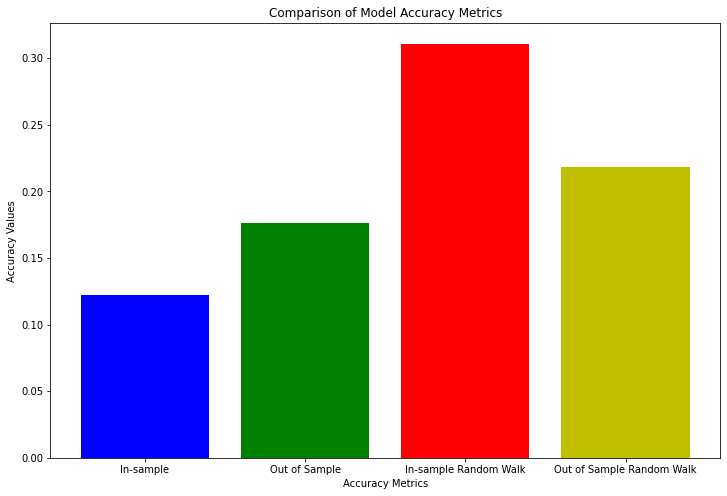

In [39]:
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize = (12, 8))
metrics = ['In-sample', 'Out of Sample', 'In-sample Random Walk', 'Out of Sample Random Walk']
accuracy_values = [in_sample_acc, out_of_sample_acc, in_sample_rw_acc, out_of_sample_rw_acc]
colors = ['b', 'g', 'r', 'y']

plt.bar(metrics, accuracy_values, color=colors)

# Add labels and title
plt.xlabel('Accuracy Metrics')
plt.ylabel('Accuracy Values')
plt.title('Comparison of Model Accuracy Metrics')

# Show the plot
plt.show()

# 4.) Plot in and out of sample accuracy

51/51 [==============================] - 0s 4ms/step


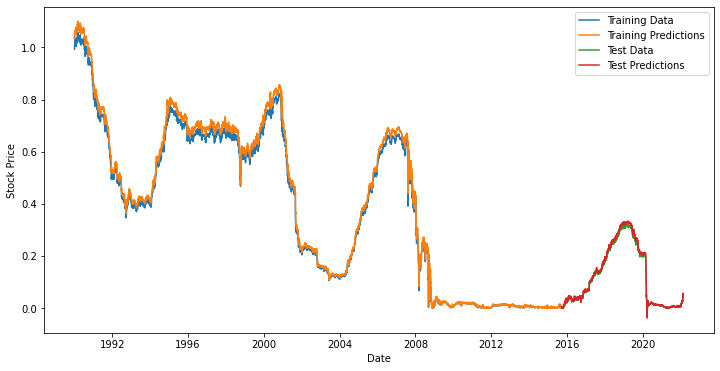

In [42]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

plt.figure(figsize = (12, 6))
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

From the plot above, we can find that either for in sample data or out of sample data, random walk usually has a higher accuracy.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim=60, activation='LSTM'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
#param_grid = {'batch_size': [10, 20, 100],
#              'epochs': [10, 100],
#              'neurons':[5,10,20]}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-55-f5508c983bfa>:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.000000 using {'batch_size': 10, 'epochs': 10}
